In [0]:
!nvidia-smi

Tue Dec 10 18:38:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!ps -aux | grep python

root          19  0.6  0.7 402904 98292 ?        Sl   18:34   0:01 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         124 14.9  1.1 644092 150972 ?       Ssl  18:38   0:01 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-7c078483-ca9e-41de-b2cc-6505b45c2b5a.json
root         147  0.0  0.0  39196  6568 ?        S    18:38   0:00 /bin/bash -c ps -aux | grep python


# **Import and Load data**

In [0]:
import pandas as pd
import numpy as np
from PIL import Image
import shutil
from torchvision import models
import torch.nn as nn
import torch
import json
import time
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from zipfile import ZipFile 
from keras.preprocessing.image import load_img, save_img, img_to_array
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Define Models**

In [0]:
with ZipFile("/content/gdrive/My Drive/Painting Dataset/train.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content') 
with ZipFile("/content/gdrive/My Drive/Painting Dataset/val.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content')    

In [0]:
train_directory = 'train'
val_directory = 'val'
preprocess = transforms.Compose([
              transforms.RandomResizedCrop(224), # random resized crop is used 
                                                 # for data augmentation
              transforms.ToTensor(), 
              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
              ])
train_data = ImageFolder(train_directory, transform=preprocess)

val_data = ImageFolder(val_directory, transform=preprocess)
print(len(train_data))
print(len(val_data))

13512
3380


In [0]:
n_category = 50
# Resnet 18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, n_category)
# Resnet 50
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, n_category)
# Resnet 101
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Linear(2048, n_category)
# GoogleNet
googleNet = models.googlenet(pretrained=True)
googleNet.fc = nn.Linear(1024, n_category)
# VGG 11 with batch normalization
vgg11 = models.vgg11_bn(pretrained=False)
vgg11.classifier[6] = nn.Linear(4096, n_category)
# VGG 19 with batch normalization
vgg19 = models.vgg19_bn(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, n_category)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.2MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:05<00:00, 32.5MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:02<00:00, 19.1MB/s]
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:15<00:00, 36.4MB/s]


# **Model Training**

In [0]:
!pip install tqdm --upgrade

     |████████████████████████████████| 61kB 3.0MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score, precision_score
def train(classifier, criterion, optimizer, trainLoader, device):
    epoch_loss = 0
    epoch_correct = 0
    classifier.train()
    record_pred = torch.FloatTensor().cpu()
    record_gt = torch.LongTensor().cpu()
    for i, (x, y) in tqdm(enumerate(trainLoader)):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = classifier(x)
        loss = criterion(predictions, y)
        # print('predictions.size()',predictions.size())
        epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()

        record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
        record_gt = torch.cat([record_gt, y.cpu()], dim=0)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    record_pred = record_pred.view(-1)
    record_gt = record_gt.view(-1)
    f1 = f1_score(record_gt, record_pred, average='weighted')
    precision = precision_score(record_gt, record_pred, average='weighted')
    recall = recall_score(record_gt, record_pred, average='weighted')
    print('Train f1', f1)
    print('Train precision', precision)
    print('Train recall', recall)
    return epoch_loss / len(trainLoader.dataset), epoch_correct / len(trainLoader.dataset), f1, precision, recall

def evaluate(classifier, criterion, optimizer, validLoader, device):
  epoch_loss = 0
  epoch_correct = 0
  classifier.eval()
  record_pred = torch.FloatTensor().cpu()
  record_gt = torch.LongTensor().cpu()
  with torch.no_grad():
      for i, (x, y) in tqdm(enumerate(validLoader)):
          x, y = x.to(device), y.to(device)

          predictions = classifier(x)
          
          loss = criterion(predictions, y)
          record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
          record_gt = torch.cat([record_gt, y.cpu()], dim=0)

          epoch_loss += loss.item()
          epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()
      record_pred = record_pred.view(-1)
      record_gt = record_gt.view(-1)
      f1 = f1_score(record_gt, record_pred, average='weighted')
      precision = precision_score(record_gt, record_pred, average='weighted')
      recall = recall_score(record_gt, record_pred, average='weighted')
      print('Val f1', f1)
      print('Val precision', precision)
      print('Val recall', recall)
  return epoch_loss / len(validLoader.dataset), epoch_correct / len(validLoader.dataset)

def plot_result(train_acc, val_acc, train_loss, val_loss):
  epochs = np.arange(0, 60)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=600)
  ax1.set_title('Train and Validation Accuracy over Epochs')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.plot(epochs, train_acc, label='training accuracy')
  ax1.plot(epochs, val_acc, label='validation accuracy')
  ax1.legend()

  ax2.set_title('Train and Validation Loss over Epochs')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.plot(epochs, train_loss, label='training loss')
  ax2.plot(epochs, val_loss, label='validation loss')
  ax2.legend()
  fig.savefig('vgg11_loss_acc(2).png', dpi=600)

In [0]:
def train_model(classifier, criterion, optimizer, 
                trainSet, testSet, n_epochs = 60):
    params = {  
        'batch_size':64,
        'shuffle':True,
        'num_workers':0,
    }
    train_ls_acc, valid_ls_acc = [], []
    for epoch in range(n_epochs):
        train_loader = DataLoader(trainSet, **params)
        val_loader = DataLoader(testSet, **params)

        start_time = time.time()
        
        train_loss, train_acc, f1_t, p_t, r_t = train(classifier, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = evaluate(classifier, criterion, optimizer, val_loader, device)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        epoch_mins = int(elapsed_time/60)
        epoch_secs = int(elapsed_time - epoch_mins*60)
        
        train_ls_acc.append((train_loss, train_acc))
        valid_ls_acc.append((valid_loss, valid_acc))
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return train_ls_acc, valid_ls_acc

**Train VGG11**

In [0]:
model = resnet18.to(device)
criterion = nn.CrossEntropyLoss().to(device)
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr)
train_ls_acc, valid_ls_acc = train_model(model, criterion, optimizer, train_data, val_data)


Train f1 0.05943277670468797
Train precision 0.07238126916879446
Train recall 0.1279603315571344


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Val f1 0.08864551105389112
Val precision 0.1030183773488921
Val recall 0.17633136094674556
Epoch: 01 | Epoch Time: 7m 27s
	Train Loss: 0.057 | Train Acc: 12.80%
	 Val. Loss: 0.053 |  Val. Acc: 17.63%



Train f1 0.12136572721941856
Train precision 0.16685532262113248
Train recall 0.207445233866193



Val f1 0.14843174729645273
Val precision 0.18512955540571446
Val recall 0.23846153846153847
Epoch: 02 | Epoch Time: 7m 4s
	Train Loss: 0.051 | Train Acc: 20.74%
	 Val. Loss: 0.050 |  Val. Acc: 23.85%



Train f1 0.18940173972126778
Train precision 0.23511982584968874
Train recall 0.2710923623445826



Val f1 0.2041406898684884
Val precision 0.20459138646112116
Val recall 0.29289940828402367
Epoch: 03 | Epoch Time: 7m 2s
	Train Loss: 0.048 | Train Acc: 27.11%
	 Val. Loss: 0.046 |  Val. Acc: 29.29%



Train f1 0.2338967134731229
Train precision 0.2863301175277055
Train recall 0.32001184132622856



Val f1 0.24565985955541603
Val precision 0.28045034557146825
Val recall 0.33224852071005917
Epoch: 04 | Epoch Time: 7m 2s
	Train Loss: 0.044 | Train Acc: 32.00%
	 Val. Loss: 0.043 |  Val. Acc: 33.22%



Train f1 0.27418129713597783
Train precision 0.3253084017852251
Train recall 0.3567199526346951



Val f1 0.27987619530981256
Val precision 0.31311276025248724
Val recall 0.3633136094674556
Epoch: 05 | Epoch Time: 7m 1s
	Train Loss: 0.042 | Train Acc: 35.67%
	 Val. Loss: 0.041 |  Val. Acc: 36.33%



Train f1 0.3061159366351521
Train precision 0.3615589903377501
Train recall 0.3852131438721137



Val f1 0.2996889051825647
Val precision 0.368347113801225
Val recall 0.378698224852071
Epoch: 06 | Epoch Time: 7m 2s
	Train Loss: 0.039 | Train Acc: 38.52%
	 Val. Loss: 0.039 |  Val. Acc: 37.87%



Train f1 0.3348309189362931
Train precision 0.39610768763094206
Train recall 0.41156009473060984



Val f1 0.34138653579470596
Val precision 0.3842515086734831
Val recall 0.42011834319526625
Epoch: 07 | Epoch Time: 7m 3s
	Train Loss: 0.037 | Train Acc: 41.16%
	 Val. Loss: 0.037 |  Val. Acc: 42.01%



Train f1 0.36802966717676744
Train precision 0.43801064548902446
Train recall 0.43849911190053287



Val f1 0.3641388841009355
Val precision 0.434393050741088
Val recall 0.43431952662721895
Epoch: 08 | Epoch Time: 7m 1s
	Train Loss: 0.035 | Train Acc: 43.85%
	 Val. Loss: 0.036 |  Val. Acc: 43.43%



Train f1 0.3925626474930846
Train precision 0.45420529238823565
Train recall 0.46121965660153935



Val f1 0.3802286043398468
Val precision 0.4455207594073727
Val recall 0.44733727810650886
Epoch: 09 | Epoch Time: 7m 6s
	Train Loss: 0.034 | Train Acc: 46.12%
	 Val. Loss: 0.034 |  Val. Acc: 44.73%



Train f1 0.42104869347538915
Train precision 0.4944053760963355
Train recall 0.4812018946121966



Val f1 0.40077784329623917
Val precision 0.46172470826847306
Val recall 0.46597633136094674
Epoch: 10 | Epoch Time: 7m 5s
	Train Loss: 0.033 | Train Acc: 48.12%
	 Val. Loss: 0.033 |  Val. Acc: 46.60%



Train f1 0.4388461946448218
Train precision 0.4789923160670452
Train recall 0.4988898756660746



Val f1 0.41821495632812744
Val precision 0.43407216262180137
Val recall 0.47781065088757396
Epoch: 11 | Epoch Time: 7m 2s
	Train Loss: 0.031 | Train Acc: 49.89%
	 Val. Loss: 0.032 |  Val. Acc: 47.78%



Train f1 0.4576565137643812
Train precision 0.5104338163936839
Train recall 0.5130254588513914



Val f1 0.4291445719751078
Val precision 0.45027099792998393
Val recall 0.48579881656804735
Epoch: 12 | Epoch Time: 7m 4s
	Train Loss: 0.030 | Train Acc: 51.30%
	 Val. Loss: 0.031 |  Val. Acc: 48.58%



Train f1 0.4782318935457518
Train precision 0.5326610794670794
Train recall 0.5288632326820604



Val f1 0.4579547303361628
Val precision 0.49718065216890955
Val recall 0.508284023668639
Epoch: 13 | Epoch Time: 7m 6s
	Train Loss: 0.029 | Train Acc: 52.89%
	 Val. Loss: 0.030 |  Val. Acc: 50.83%



Train f1 0.4998007903354559
Train precision 0.5518701483245535
Train recall 0.5474393132030787



Val f1 0.4744632603321335
Val precision 0.5083555977109533
Val recall 0.5207100591715976
Epoch: 14 | Epoch Time: 7m 11s
	Train Loss: 0.028 | Train Acc: 54.74%
	 Val. Loss: 0.029 |  Val. Acc: 52.07%



Train f1 0.5126845683432186
Train precision 0.5610499975398944
Train recall 0.5584665482534044



Val f1 0.4749003019407951
Val precision 0.5053238534301164
Val recall 0.5144970414201183
Epoch: 15 | Epoch Time: 7m 3s
	Train Loss: 0.027 | Train Acc: 55.85%
	 Val. Loss: 0.029 |  Val. Acc: 51.45%



Train f1 0.5242468481063732
Train precision 0.5834401137740693
Train recall 0.5671255180580225



Val f1 0.5010921704677976
Val precision 0.5185913512783847
Val recall 0.5402366863905326
Epoch: 16 | Epoch Time: 7m 2s
	Train Loss: 0.026 | Train Acc: 56.71%
	 Val. Loss: 0.027 |  Val. Acc: 54.02%



Train f1 0.5376272672612307
Train precision 0.578708479413524
Train recall 0.5775606867969213



Val f1 0.4982289509830293
Val precision 0.5326636325363998
Val recall 0.5396449704142012
Epoch: 17 | Epoch Time: 6m 56s
	Train Loss: 0.026 | Train Acc: 57.76%
	 Val. Loss: 0.027 |  Val. Acc: 53.96%



Train f1 0.5528240049234884
Train precision 0.5896534533175477
Train recall 0.5910301953818827



Val f1 0.5132551951711973
Val precision 0.5326186552328579
Val recall 0.5494082840236686
Epoch: 18 | Epoch Time: 6m 55s
	Train Loss: 0.025 | Train Acc: 59.10%
	 Val. Loss: 0.026 |  Val. Acc: 54.94%



Train f1 0.5588641644342716
Train precision 0.5963497416995509
Train recall 0.5958407341622262



Val f1 0.5227723961467805
Val precision 0.5523226269011052
Val recall 0.5553254437869822
Epoch: 19 | Epoch Time: 6m 56s
	Train Loss: 0.024 | Train Acc: 59.58%
	 Val. Loss: 0.026 |  Val. Acc: 55.53%



Train f1 0.5663560873438119
Train precision 0.6024454362412812
Train recall 0.6014653641207816



Val f1 0.5460127714103707
Val precision 0.5735009289093497
Val recall 0.5789940828402367
Epoch: 20 | Epoch Time: 7m 2s
	Train Loss: 0.024 | Train Acc: 60.15%
	 Val. Loss: 0.025 |  Val. Acc: 57.90%



Train f1 0.5811950705450095
Train precision 0.6072170507777788
Train recall 0.6139727649496743



Val f1 0.5521788303495513
Val precision 0.5757064229854161
Val recall 0.5807692307692308
Epoch: 21 | Epoch Time: 7m 3s
	Train Loss: 0.023 | Train Acc: 61.40%
	 Val. Loss: 0.025 |  Val. Acc: 58.08%



Train f1 0.5889458123213808
Train precision 0.6137248673354117
Train recall 0.6199674363528715



Val f1 0.5563306189670174
Val precision 0.5854264093087909
Val recall 0.5837278106508875
Epoch: 22 | Epoch Time: 7m 3s
	Train Loss: 0.023 | Train Acc: 62.00%
	 Val. Loss: 0.024 |  Val. Acc: 58.37%



Train f1 0.5986378408032478
Train precision 0.6218091538972896
Train recall 0.6281823564239195



Val f1 0.5617230776892417
Val precision 0.5788427788056282
Val recall 0.5899408284023668
Epoch: 23 | Epoch Time: 7m 4s
	Train Loss: 0.022 | Train Acc: 62.82%
	 Val. Loss: 0.024 |  Val. Acc: 58.99%



Train f1 0.6085927616908544
Train precision 0.6385112597581605
Train recall 0.6355831853167555



Val f1 0.5644985064975008
Val precision 0.5912760848544936
Val recall 0.5911242603550296
Epoch: 24 | Epoch Time: 6m 59s
	Train Loss: 0.021 | Train Acc: 63.56%
	 Val. Loss: 0.024 |  Val. Acc: 59.11%



Train f1 0.6184274325903905
Train precision 0.6398365521545668
Train recall 0.6443901716992303



Val f1 0.5929938037025239
Val precision 0.6205919291096114
Val recall 0.6150887573964497
Epoch: 25 | Epoch Time: 7m 2s
	Train Loss: 0.021 | Train Acc: 64.44%
	 Val. Loss: 0.023 |  Val. Acc: 61.51%



Train f1 0.6303900782321709
Train precision 0.659001122214965
Train recall 0.6545293072824157



Val f1 0.5884415256337232
Val precision 0.6024415202596543
Val recall 0.6106508875739645
Epoch: 26 | Epoch Time: 7m 5s
	Train Loss: 0.021 | Train Acc: 65.45%
	 Val. Loss: 0.023 |  Val. Acc: 61.07%



Train f1 0.6365421945867561
Train precision 0.6591484492493096
Train recall 0.6607460035523979



Val f1 0.5951458152716698
Val precision 0.619401792460993
Val recall 0.6171597633136094
Epoch: 27 | Epoch Time: 7m 5s
	Train Loss: 0.020 | Train Acc: 66.07%
	 Val. Loss: 0.023 |  Val. Acc: 61.72%



Train f1 0.6423232575849595
Train precision 0.6695596321380008
Train recall 0.6644464179988159



Val f1 0.585983172775857
Val precision 0.6081404669207005
Val recall 0.6076923076923076
Epoch: 28 | Epoch Time: 7m 6s
	Train Loss: 0.020 | Train Acc: 66.44%
	 Val. Loss: 0.022 |  Val. Acc: 60.77%



Train f1 0.6457724032790304
Train precision 0.6640371395278282
Train recall 0.6674807578448786



Val f1 0.6012054088686728
Val precision 0.6182495524784447
Val recall 0.6227810650887574
Epoch: 29 | Epoch Time: 7m 5s
	Train Loss: 0.020 | Train Acc: 66.75%
	 Val. Loss: 0.022 |  Val. Acc: 62.28%



Train f1 0.6578271465202874
Train precision 0.6722533932666626
Train recall 0.6783599763173476



Val f1 0.6102796201546066
Val precision 0.6231035583194547
Val recall 0.6292899408284024
Epoch: 30 | Epoch Time: 7m 5s
	Train Loss: 0.019 | Train Acc: 67.84%
	 Val. Loss: 0.022 |  Val. Acc: 62.93%



Train f1 0.6652013607556322
Train precision 0.6838831470803906
Train recall 0.6856867969212552



Val f1 0.6160975344625804
Val precision 0.6312935082578741
Val recall 0.6352071005917159
Epoch: 31 | Epoch Time: 7m 5s
	Train Loss: 0.019 | Train Acc: 68.57%
	 Val. Loss: 0.022 |  Val. Acc: 63.52%



Train f1 0.6682319655146387
Train precision 0.6896521633009127
Train recall 0.6873149792776792



Val f1 0.6058957673434191
Val precision 0.6238947623761285
Val recall 0.6239644970414201
Epoch: 32 | Epoch Time: 7m 4s
	Train Loss: 0.018 | Train Acc: 68.73%
	 Val. Loss: 0.021 |  Val. Acc: 62.40%



Train f1 0.6798016010256591
Train precision 0.7000196055242739
Train recall 0.6971580817051509



Val f1 0.6207021175388621
Val precision 0.630330075429975
Val recall 0.6366863905325444
Epoch: 33 | Epoch Time: 7m 6s
	Train Loss: 0.018 | Train Acc: 69.72%
	 Val. Loss: 0.021 |  Val. Acc: 63.67%



Train f1 0.6811604553300554
Train precision 0.6987155970154502
Train recall 0.6978241563055062



Val f1 0.6281116047034446
Val precision 0.6482355171472951
Val recall 0.6467455621301775
Epoch: 34 | Epoch Time: 6m 57s
	Train Loss: 0.018 | Train Acc: 69.78%
	 Val. Loss: 0.021 |  Val. Acc: 64.67%



Train f1 0.6851273660957234
Train precision 0.7050352009358726
Train recall 0.7011545293072824



Val f1 0.6320060442663566
Val precision 0.6427505340060305
Val recall 0.6485207100591716
Epoch: 35 | Epoch Time: 6m 56s
	Train Loss: 0.017 | Train Acc: 70.12%
	 Val. Loss: 0.020 |  Val. Acc: 64.85%



Train f1 0.6891672451083937
Train precision 0.7075240840882373
Train recall 0.7050029603315572



Val f1 0.6357387166152741
Val precision 0.6518309285608866
Val recall 0.6514792899408284
Epoch: 36 | Epoch Time: 6m 54s
	Train Loss: 0.017 | Train Acc: 70.50%
	 Val. Loss: 0.020 |  Val. Acc: 65.15%



Train f1 0.694326170893932
Train precision 0.7115976094299213
Train recall 0.7099615156897573



Val f1 0.6495523318288665
Val precision 0.656627071796683
Val recall 0.6653846153846154
Epoch: 37 | Epoch Time: 6m 53s
	Train Loss: 0.017 | Train Acc: 71.00%
	 Val. Loss: 0.020 |  Val. Acc: 66.54%



Train f1 0.7005735455621518
Train precision 0.718738846895065
Train recall 0.7144760213143873



Val f1 0.6422461671513681
Val precision 0.6548424889934144
Val recall 0.6576923076923077
Epoch: 38 | Epoch Time: 6m 54s
	Train Loss: 0.017 | Train Acc: 71.45%
	 Val. Loss: 0.020 |  Val. Acc: 65.77%



Train f1 0.705431339717215
Train precision 0.7185803670964418
Train recall 0.7196566015393724



Val f1 0.647226533084339
Val precision 0.6568879191047258
Val recall 0.6612426035502958
Epoch: 39 | Epoch Time: 6m 54s
	Train Loss: 0.016 | Train Acc: 71.97%
	 Val. Loss: 0.019 |  Val. Acc: 66.12%



Train f1 0.7054753397727846
Train precision 0.7194896648757546
Train recall 0.7196566015393724



Val f1 0.6503321059770667
Val precision 0.6640827464961
Val recall 0.6644970414201183
Epoch: 40 | Epoch Time: 6m 55s
	Train Loss: 0.016 | Train Acc: 71.97%
	 Val. Loss: 0.020 |  Val. Acc: 66.45%



Train f1 0.7193676297089019
Train precision 0.7296999380784692
Train recall 0.7322380106571936



Val f1 0.6477546433067257
Val precision 0.6591716598246946
Val recall 0.6618343195266272
Epoch: 41 | Epoch Time: 6m 56s
	Train Loss: 0.016 | Train Acc: 73.22%
	 Val. Loss: 0.019 |  Val. Acc: 66.18%



Train f1 0.713199272442728
Train precision 0.7236860481408258
Train recall 0.7259473060982831



Val f1 0.656970422988919
Val precision 0.6725283332388904
Val recall 0.669526627218935
Epoch: 42 | Epoch Time: 6m 56s
	Train Loss: 0.016 | Train Acc: 72.59%
	 Val. Loss: 0.019 |  Val. Acc: 66.95%



Train f1 0.7285183574228338
Train precision 0.7420839545010018
Train recall 0.7402309058614565



Val f1 0.6658996513011507
Val precision 0.6813355352514192
Val recall 0.6775147928994083
Epoch: 43 | Epoch Time: 6m 55s
	Train Loss: 0.015 | Train Acc: 74.02%
	 Val. Loss: 0.019 |  Val. Acc: 67.75%



Train f1 0.7300946874786151
Train precision 0.7391397888873389
Train recall 0.7410449970396684



Val f1 0.6605151442752796
Val precision 0.6685905759505792
Val recall 0.6736686390532545
Epoch: 44 | Epoch Time: 6m 55s
	Train Loss: 0.015 | Train Acc: 74.10%
	 Val. Loss: 0.019 |  Val. Acc: 67.37%



Train f1 0.7300728764991832
Train precision 0.7393268351577248
Train recall 0.7412670219064535



Val f1 0.6562636528637021
Val precision 0.6696398583677101
Val recall 0.6674556213017752
Epoch: 45 | Epoch Time: 6m 55s
	Train Loss: 0.015 | Train Acc: 74.13%
	 Val. Loss: 0.019 |  Val. Acc: 66.75%



Train f1 0.7328915429226608
Train precision 0.7421693603826144
Train recall 0.7443013617525163



Val f1 0.6623681262543444
Val precision 0.6751537264180261
Val recall 0.6742603550295858
Epoch: 46 | Epoch Time: 6m 56s
	Train Loss: 0.015 | Train Acc: 74.43%
	 Val. Loss: 0.018 |  Val. Acc: 67.43%



Train f1 0.7402025263027787
Train precision 0.7472042306848878
Train recall 0.7501480165778567



Val f1 0.664360787955245
Val precision 0.669753354542314
Val recall 0.676923076923077
Epoch: 47 | Epoch Time: 7m 0s
	Train Loss: 0.014 | Train Acc: 75.01%
	 Val. Loss: 0.018 |  Val. Acc: 67.69%



Train f1 0.7456457386453933
Train precision 0.7563313595897644
Train recall 0.7561426879810539



Val f1 0.6841039248107897
Val precision 0.6949147336233021
Val recall 0.6937869822485208
Epoch: 48 | Epoch Time: 7m 2s
	Train Loss: 0.014 | Train Acc: 75.61%
	 Val. Loss: 0.018 |  Val. Acc: 69.38%



Train f1 0.7431264701546669
Train precision 0.7521377092356778
Train recall 0.7531083481349912



Val f1 0.6809444852060297
Val precision 0.6845848159484469
Val recall 0.6920118343195266
Epoch: 49 | Epoch Time: 7m 4s
	Train Loss: 0.014 | Train Acc: 75.31%
	 Val. Loss: 0.018 |  Val. Acc: 69.20%



Train f1 0.7517452658294226
Train precision 0.759915766202151
Train recall 0.7611752516281823



Val f1 0.6682084802337984
Val precision 0.6774830609881362
Val recall 0.6801775147928995
Epoch: 50 | Epoch Time: 7m 4s
	Train Loss: 0.014 | Train Acc: 76.12%
	 Val. Loss: 0.018 |  Val. Acc: 68.02%



Train f1 0.751534980087907
Train precision 0.7579126510128553
Train recall 0.760287152161042



Val f1 0.6855912387437488
Val precision 0.6937939945115956
Val recall 0.6946745562130178
Epoch: 51 | Epoch Time: 7m 2s
	Train Loss: 0.014 | Train Acc: 76.03%
	 Val. Loss: 0.017 |  Val. Acc: 69.47%



Train f1 0.7569273701384838
Train precision 0.7626852783649237
Train recall 0.7655417406749556



Val f1 0.6760377558295579
Val precision 0.681959364136604
Val recall 0.6884615384615385
Epoch: 52 | Epoch Time: 7m 1s
	Train Loss: 0.014 | Train Acc: 76.55%
	 Val. Loss: 0.018 |  Val. Acc: 68.85%



Train f1 0.7624980165187987
Train precision 0.7689571751689233
Train recall 0.7699822380106572



Val f1 0.6871068234955784
Val precision 0.6978471479291622
Val recall 0.6988165680473373
Epoch: 53 | Epoch Time: 7m 4s
	Train Loss: 0.013 | Train Acc: 77.00%
	 Val. Loss: 0.017 |  Val. Acc: 69.88%



Train f1 0.764456608483517
Train precision 0.7703813634475332
Train recall 0.7719064535227945



Val f1 0.6875480434420679
Val precision 0.6974739423959098
Val recall 0.6979289940828403
Epoch: 54 | Epoch Time: 7m 1s
	Train Loss: 0.013 | Train Acc: 77.19%
	 Val. Loss: 0.017 |  Val. Acc: 69.79%



Train f1 0.7703579024661641
Train precision 0.7742919947995341
Train recall 0.7781231497927767



Val f1 0.689451840807747
Val precision 0.7004985954200537
Val recall 0.6982248520710059
Epoch: 55 | Epoch Time: 6m 55s
	Train Loss: 0.013 | Train Acc: 77.81%
	 Val. Loss: 0.017 |  Val. Acc: 69.82%



Train f1 0.7660832317048938
Train precision 0.7731028734508837
Train recall 0.7731645944345766



Val f1 0.6985908683386851
Val precision 0.703301279376138
Val recall 0.7073964497041421
Epoch: 56 | Epoch Time: 7m 1s
	Train Loss: 0.013 | Train Acc: 77.32%
	 Val. Loss: 0.017 |  Val. Acc: 70.74%



Train f1 0.7682262789197615
Train precision 0.772486879500644
Train recall 0.7758288928359977



Val f1 0.6922572874498214
Val precision 0.6957869724334407
Val recall 0.7011834319526628
Epoch: 57 | Epoch Time: 7m 3s
	Train Loss: 0.013 | Train Acc: 77.58%
	 Val. Loss: 0.017 |  Val. Acc: 70.12%



Train f1 0.7741497722021655
Train precision 0.7803201058501054
Train recall 0.7824156305506217



Val f1 0.6862187469098147
Val precision 0.6913696604631449
Val recall 0.6955621301775148
Epoch: 58 | Epoch Time: 7m 1s
	Train Loss: 0.013 | Train Acc: 78.24%
	 Val. Loss: 0.017 |  Val. Acc: 69.56%



Train f1 0.7734842413860734
Train precision 0.777993618982165
Train recall 0.7810834813499112



Val f1 0.6975698587323376
Val precision 0.7011409195581279
Val recall 0.7050295857988166
Epoch: 59 | Epoch Time: 7m 2s
	Train Loss: 0.012 | Train Acc: 78.11%
	 Val. Loss: 0.017 |  Val. Acc: 70.50%



Train f1 0.780338426146341
Train precision 0.7848325001385515
Train recall 0.7867821195973949



Val f1 0.70135651128606
Val precision 0.7061450773674361
Val recall 0.7106508875739646
Epoch: 60 | Epoch Time: 7m 2s
	Train Loss: 0.012 | Train Acc: 78.68%
	 Val. Loss: 0.017 |  Val. Acc: 71.07%


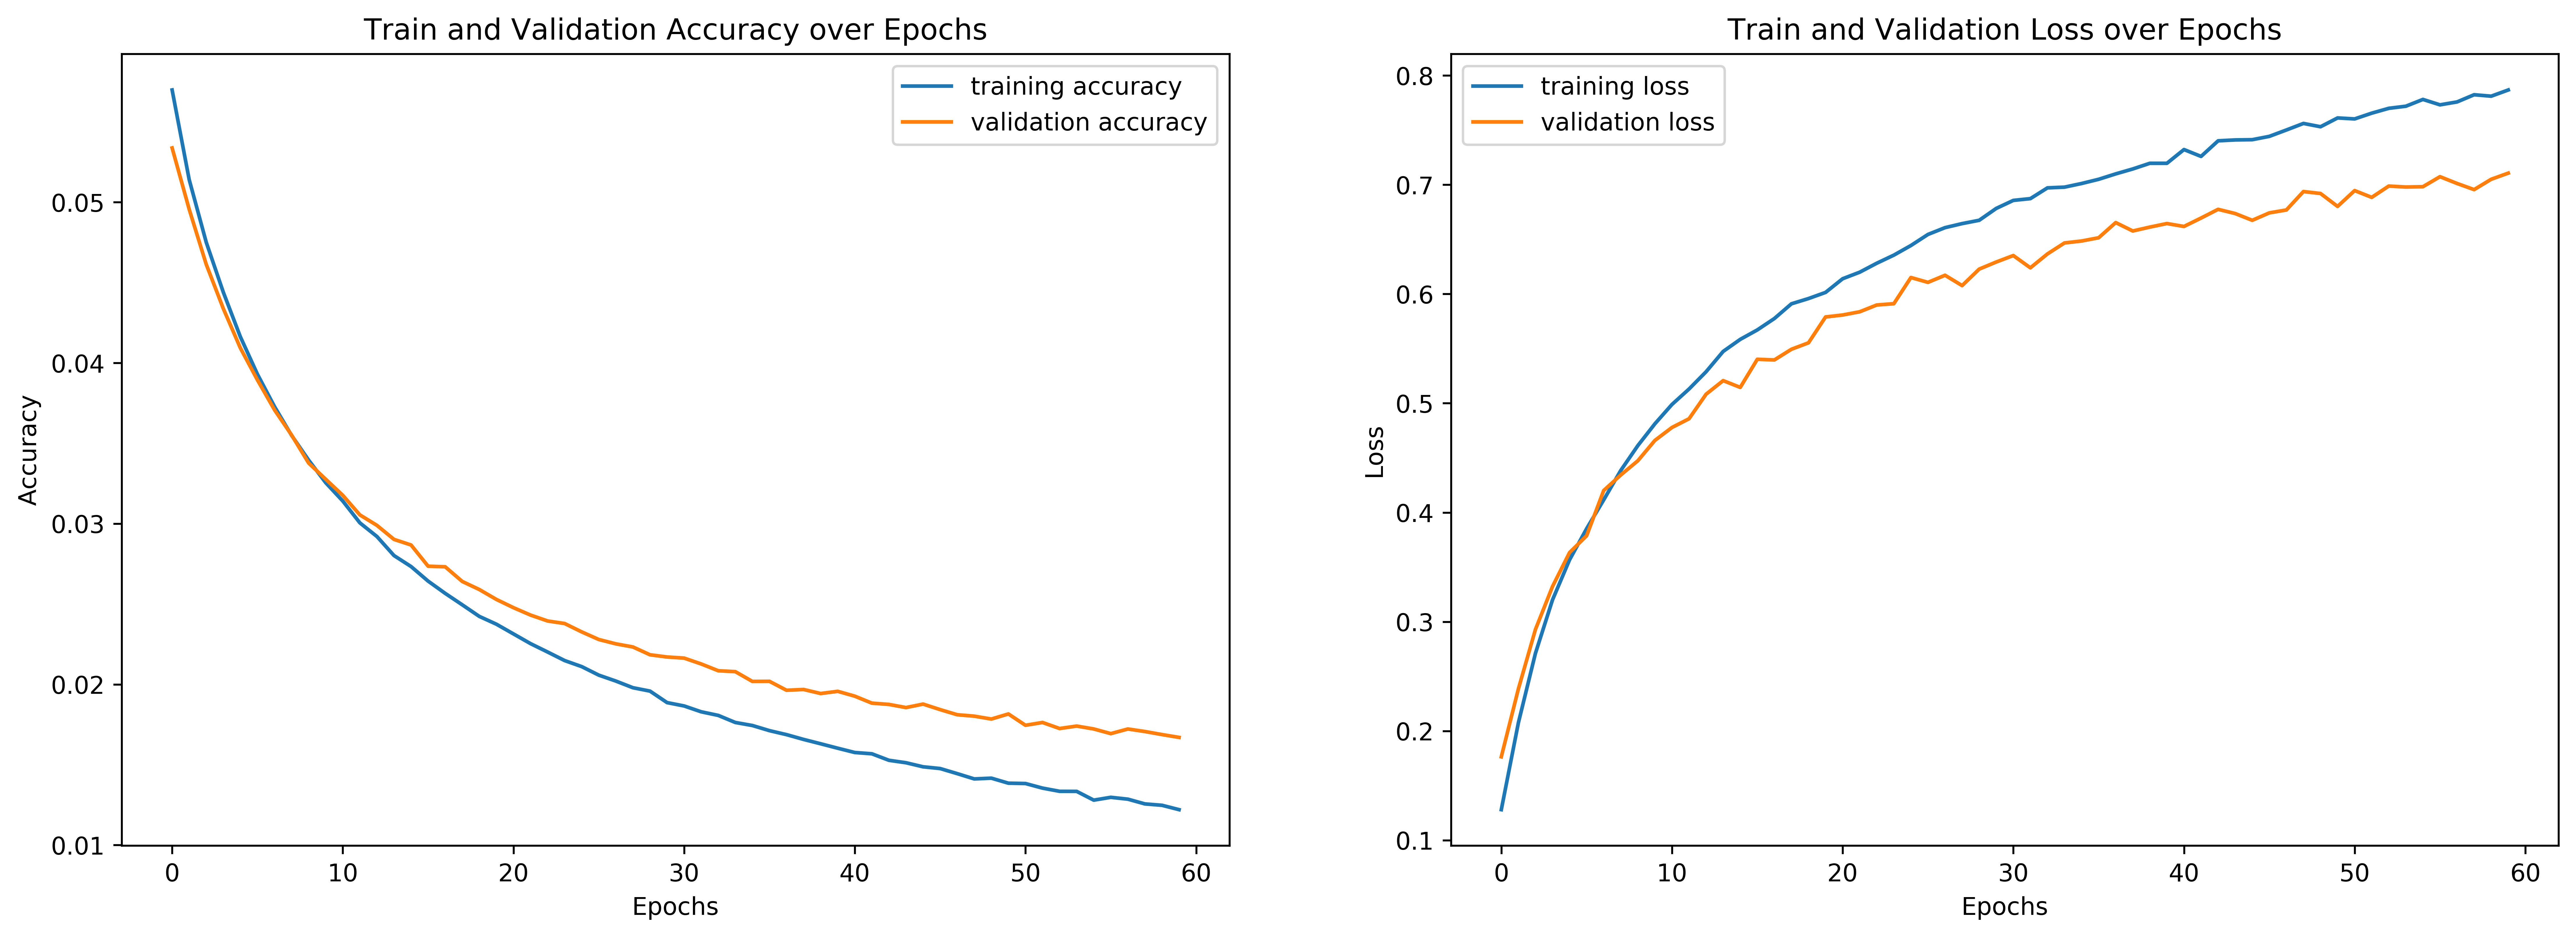

In [0]:
all_train_acc = [l[0] for l in train_ls_acc]
all_train_loss = [l[1] for l in train_ls_acc]
all_val_acc = [l[0] for l in valid_ls_acc]
all_val_loss = [l[1] for l in valid_ls_acc]
plot_result(all_train_acc,all_val_acc,all_train_loss,all_val_loss)